In [1]:
import matplotlib as mpl #画图用的库
import matplotlib.pyplot as plt
#下面这一句是为了可以在notebook中画图
%matplotlib inline
import numpy as np
import sklearn   #机器学习算法库
import pandas as pd #处理数据的库   
import os
import sys
import time
import tensorflow as tf
 
from tensorflow import keras   #使用tensorflow中的keras
#import keras #单纯的使用keras
 
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, pd, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
sklearn 0.21.3
pandas 0.25.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_dir  = "/home/galaxy/DeepLearning/DATASETS/10-Monkey-Species/training/training/"
valid_dir  = "/home/galaxy/DeepLearning/DATASETS/10-Monkey-Species/validation/validation/"
label_file = "/home/galaxy/DeepLearning/DATASETS/10-Monkey-Species/monkey_labels.txt"

print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n9', 'n8', 'n3', 'n1', 'n5', 'n6', 'n2', 'n0', 'n7', 'n4']
['n9', 'n8', 'n3', 'n1', 'n5', 'n6', 'n2', 'n0', 'n7', 'n4']


In [4]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [5]:
##################################
####该模块主要用于获取文件夹下的图片####
##################################

#resnet50使用的图像宽高均为224
#height      = 224
#width       = 224
height      = 128 #设置图像被缩放的宽高
width       = 128
channels    = 3   #图像通道数
batch_size  = 32
num_classes = 10

##########------------训练集数据------------##########
#初始化一个训练数据相关的generator
#具体用于 数据集中的图片数据进行处理，可以对图片数据进行归一化、旋转、翻转等数据增强类操作
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input,#resnet50专门用来预处理图像的函数，把图像做归一化到-1~1之间
    # 使用第一行preprocessing_function 就不需要 rescale
    #rescale           = 1./255, #放缩因子, 除以255是因为图片中每个像素点值范围都在0~255之间
    rotation_range    = 40,  #图片随机转动的角度范围(-40 ~ 40)
    width_shift_range = 0.2, #值 < 1时，表示偏移的比例，即在 0～值 这个比例幅度之间进行偏移
    height_shift_range= 0.2, #值 > 1时，表示像素宽度，即该图片的偏移幅度大小
    shear_range       = 0.2, #剪切强度
    zoom_range        = 0.2, #缩放强度
    horizontal_flip   = True,#水平随机翻转
    fill_mode         = 'nearest',#像素填充模式
)
#接下来读取目录下的图片然后按照上面的数据增强相关操作对图片进行处理
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (height,width), #目录下的图片会被resize的大小
                                                    batch_size  = batch_size,
                                                    seed        = 7,#随机种子，用于洗牌和转换，随便给个数即可
                                                    shuffle     = True,#False->则按字母数字顺序对数据进行排序 True->打乱数据
                                                    class_mode  = "categorical", # 该参数决定了返回的标签数组的形式
                                                    #classes     = 这个参数就是描述的 文件夹名与输出标签的对应关系
                                                   )
#classes：可选参数,为子文件夹的列表,如['dogs','cats']默认为None. 若未提供,则该类别列表将从directory下的子文件夹名称/结构自动推断。
#每一个子文件夹都会被认为是一个新的类。(类别的顺序将按照字母表顺序映射到标签值)。通过属性class_indices可获得文件夹名与类的序号的对应字典。

#使用生成器的.class_indices方法即可获取模型默认的Labels序列，文件夹名与类的序号的对应字典
print(train_generator.class_indices)


##########------------验证集数据------------##########
#初始化一个验证数据相关的generator
#验证数据集上不需要进行数据增强的相关操作，仅保留缩放即可，不然的话训练集与验证集的值的分布会不同
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input,#resnet50专门用来预处理图像的函数，相当于归一化，所以无需rescale
    #rescale           = 1./255, #放缩因子, 除以255是因为图片中每个像素点值范围都在0~255之间
)
#接下来读取目录下的图片然后按照上面的数据增强相关操作对图片进行处理
valid_generator = valid_datagen.flow_from_directory(valid_dir, 
                                                    target_size = (height,width), #目录下的图片会被resize的大小
                                                    batch_size  = batch_size,
                                                    seed        = 7,#随机种子，用于洗牌和转换，随便给个数即可
                                                    shuffle     = False,#不需要训练所以不需要打乱数据
                                                    class_mode  = "categorical", # 该参数决定了返回的标签数组的形式
                                                    )
#使用生成器的.class_indices方法即可获取模型默认的Labels序列，文件夹名与类的序号的对应字典
print(valid_generator.class_indices)

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
Found 272 images belonging to 10 classes.
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
1098 272


In [6]:
for i in range(1):
    x,y = train_generator.next()
    print(x.shape, y.shape)
    print(y)
#因为 class_mode 设置为categorical，所以label标签返回的是2D的one-hot编码标签(2-> one_hot -> [0, 0, 1])

(32, 128, 128, 3) (32, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [7]:
#使用resnet50做迁移学习

'''
#1.这里ResNet50层当做一层，只有最后一层是可以被训练的
resnet50_fine_tune = keras.models.Sequential([
    keras.applications.ResNet50(include_top=False,#include_top：是否保留顶层的全连接网络,这里最后要定义自己的softmax选False
                                pooling='avg',#‘avg’代表全局平均池化，‘max’代表全局最大值池化
                                weights='imagenet',#None代表随机初始化，即不加载预训练权重；'imagenet’代表加载预训练权重
                               ),
    keras.layers.Dense(num_classes, activation='softmax'),    
])
resnet50_fine_tune.layers[0].trainable=False #设置ResNet50这一层的参数不可训练，因为 weights='imagenet'
'''

#2.这里ResNet50中最后几层都是可以训练,我们可以在模型架构里面看到 Trainable params可训练参数会大大增加
resnet50 = keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet')
for layers in resnet50.layers[0:-5]: #这里遍历最后五层之前的layers并设置其权重相关参数不可遍历
    layers.trainable = False

resnet50_fine_tune = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes, activation='softmax'),    
])

'''
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu",input_shape=(width, height, channels)),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax"),
])
'''

#损失函数 sparse_categorical_crossentropy 和 categorical_crossentropy 的选择取决于前面设定的y值的取值类型
#如果y取值为 2D的 one-hot编码，则选择 categorical_crossentropy
#如果y取值为 1D的 整数标签，则选择 sparse_categorical_crossentropy
#前面的 tensorflow2------分类问题fashion_mnist 文章中有过相关描述
# metrics 表示选择 accuracy作为评价参数
resnet50_fine_tune.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

resnet50_fine_tune.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 1,075,210
Non-trainable params: 22,532,992
_________________________________________________________________


In [8]:
import shutil

callback_dir = "./callback_10-monkey-species"

if os.path.exists(callback_dir):
    shutil.rmtree(callback_dir)
os.mkdir(callback_dir)

output_model_file=os.path.join(callback_dir,"10Monkey_model.h5")#在logdir中创建一个模型文件.h5

callbacks = [
    keras.callbacks.TensorBoard(callback_dir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),    
]


epochs = 10#使用fine_tune 不需要太多次迭代就能够达到一个较好的效果
'''
#使用fit_generator是因为使用的是 ImageDataGenerator 获取数据集数据的
history = model.fit_generator(train_generator,#steps_per_epoch: 一个epoch包含的步数（每一步是一个batch的数据送入）
                              steps_per_epoch = train_num // batch_size,
                              epochs          = epochs,
                              validation_data = valid_generator,
                              validation_steps= valid_num // batch_size,
                              callbacks       = callbacks,
                             )
'''
history = resnet50_fine_tune.fit_generator(train_generator,#steps_per_epoch: 一个epoch包含的步数（每一步是一个batch的数据送入）
                              steps_per_epoch = train_num // batch_size,
                              epochs          = epochs,
                              validation_data = valid_generator,
                              validation_steps= valid_num // batch_size,
                              callbacks       = callbacks,
                             )
#运行打印看到val_accuracy的值并没有逐渐变大而是一直保持不变，是因为激活函数使用的是selu导致，可尝试更换激活函数为relu

Epoch 1/10
34/34 [==============================] - 17s 506ms/step - loss: 1.0719 - accuracy: 0.6614 - val_loss: 0.7943 - val_accuracy: 0.8828
Epoch 2/10
34/34 [==============================] - 16s 470ms/step - loss: 0.5916 - accuracy: 0.8030 - val_loss: 0.8710 - val_accuracy: 0.8555
Epoch 3/10
34/34 [==============================] - 17s 493ms/step - loss: 0.4014 - accuracy: 0.8771 - val_loss: 0.6169 - val_accuracy: 0.8867
Epoch 4/10
34/34 [==============================] - 17s 497ms/step - loss: 0.3569 - accuracy: 0.8809 - val_loss: 0.2539 - val_accuracy: 0.9531
Epoch 5/10
34/34 [==============================] - 16s 476ms/step - loss: 0.3023 - accuracy: 0.8968 - val_loss: 0.4478 - val_accuracy: 0.8906
Epoch 6/10
34/34 [==============================] - 16s 466ms/step - loss: 0.2691 - accuracy: 0.9109 - val_loss: 0.7037 - val_accuracy: 0.8828
Epoch 7/10
34/34 [==============================] - 16s 485ms/step - loss: 0.2267 - accuracy: 0.9212 - val_loss: 0.7834 - val_accuracy: 0.9023

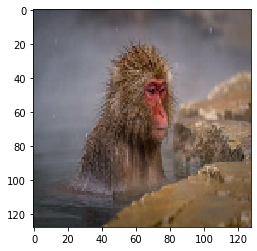

In [9]:
def preprocess_img(image):
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[width,height])
    image /= 255.0
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_img(image)


#image_path_test = '/home/galaxy/DeepLearning/DATASETS/10-Monkey-Species/testImg/white_headed_capuchin.jpg'
image_path_test = '/home/galaxy/DeepLearning/DATASETS/10-Monkey-Species/testImg/japanese_macaque.jpg'

image = load_and_preprocess_image(image_path_test)
plt.imshow(image)

In [10]:
from tensorflow.keras.preprocessing import image
import pprint

img = image.load_img(image_path_test, target_size=(height, width))
img = image.img_to_array(img)
print(img.shape)#这里直接打印将img转换为数组后的数据维度 (128,128,3)
#因为模型的输入是要求四维的，所以我们需要将输入图片增加一个维度，使用 expand_dims接口
img = np.expand_dims(img, axis=0)
print(img.shape)


#predict表示预测输出当前输入图像的 所有类型概率数组，即包含十个概率值的数组
pred = resnet50_fine_tune.predict(img)
pprint.pprint(pred)
print(np.argmax(pred,axis=1))#axis = 1是取行的最大值的索引，axis = 0是列的最大值的索引

#predict_classes 预测的是类别，打印出来的值就是类别号
pred_class = resnet50_fine_tune.predict_classes(img)
print(pred_class)

#建立对应的文件夹排序的标签数组打印出预测的标签
monkey_names = ['mantled_howler',
                'patas_monkey',
                'bald_uakari',
                'japanese_macaque',
                'pygmy_marmoset',
                'white_headed_capuchin',
                'silvery_marmoset',
                'common_squirrel_monkey',
                'black_headed_night_monkey',
                'nilgiri_langur']
label_name = [monkey_names[index] for index in pred_class]
print("This is a ",''.join(label_name))#list转换为string

(128, 128, 3)
(1, 128, 128, 3)
array([[2.86323209e-16, 1.02518805e-09, 6.43146951e-12, 9.99995470e-01,
        2.64310107e-09, 5.72158265e-10, 4.45466458e-06, 1.10910907e-11,
        9.24227888e-15, 1.14730796e-07]], dtype=float32)
[3]
[3]
This is a  japanese_macaque
